# Load data

In [1]:
from pathlib import Path
import os

data_path = Path("/kaggle/input/alfafood")

def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
walk_through_dir(data_path)

In [2]:
import random
from PIL import Image

image_path_list = list(data_path.glob("*/*.jpg"))

labels_path_list = list(data_path.glob("*/*.txt"))

print(image_path_list[:1])

random_image_path = random.choice(image_path_list)
print(random_image_path)

img = Image.open(random_image_path)

ORIGINAL_IMAGE_SHAPE = (img.size)

# Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

[]


IndexError: list index out of range

In [5]:
image_path_list.sort()

labels_path_list.sort()

In [6]:
file_path = "/kaggle/input/alfafood/objects/objects_0.txt"

with open(file_path, 'r') as file:
    file_content = file.read()

print("Содержимое файла:")
print(file_content)

lines = file_content.splitlines()
data = []

for line in lines:
    parts = line.split(' ')
    if len(parts) == 6:
        label = parts[0]
        x_center = float(parts[1])
        y_center = float(parts[2])
        width = float(parts[3])
        height = float(parts[4])
        data.append((label, x_center, y_center, width, height))

print("Обработанные данные:")
for item in data:
    print(item)


Содержимое файла:
0 0.0 0.0 1.000000013351432e-10 1.000000013351432e-10 

Обработанные данные:
('0', 0.0, 0.0, 1.000000013351432e-10, 1.000000013351432e-10)


In [7]:
from typing import Dict, List, Tuple

def create_objects_from_txt(path: Path) -> Dict[str, List]:
    with open(path, 'r') as file:
        file_content = file.read()

    lines = file_content.splitlines()
    data = dict()
    data["bboxes"], data["labels"] = list(), list()

    for line in lines:
        parts = line.split(' ')
        if len(parts) == 6:
            label = parts[0]
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])
            data["bboxes"].append([x_center, y_center, width, height])
            data["labels"].append(int(label))
        else:
            print("Invalid data format")
            raise ValueError
    return data

create_objects_from_txt(file_path)

{'bboxes': [[0.0, 0.0, 1.000000013351432e-10, 1.000000013351432e-10]],
 'labels': [0]}

In [8]:
objects = [create_objects_from_txt(file_path) for file_path in labels_path_list]

objects[0]

{'bboxes': [[0.0, 0.0, 1.000000013351432e-10, 1.000000013351432e-10]],
 'labels': [0]}

In [9]:
objects[9]

{'bboxes': [[181.51040649414062,
   103.28959655761719,
   296.3263854980469,
   281.8080139160156],
  [41.510398864746094,
   86.99199676513672,
   423.7327880859375,
   319.5856018066406],
  [57.06719970703125,
   204.7696075439453,
   112.62239837646484,
   273.6592102050781],
  [320.76959228515625,
   222.54879760742188,
   391.14080810546875,
   288.4736022949219]],
 'labels': [100, 1, 66, 33]}

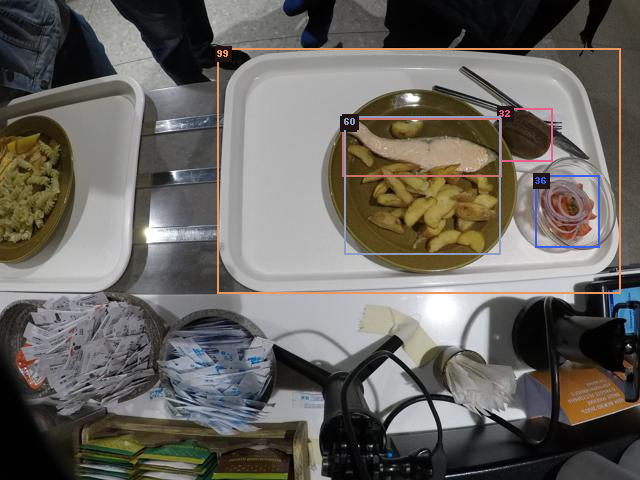

In [10]:
import torch
import numpy as np
from PIL import Image, ImageDraw

color = list((random.randint(40, 240), random.randint(40, 255), random.randint(60, 255)) for i in range(128))

def show_image_with_objects(image: np.array, 
                            bboxes: torch.Tensor, 
                            labels: torch.Tensor=None, 
                            scores: torch.Tensor=None,
                            threshold_score: float=0.5):
    image = Image.fromarray(image)
#     random.shuffle(color)

    if scores != None:
        bboxes, labels, scores = objects_threshold_scores(bboxes, labels, scores, threshold_score)

    for i in range(len(bboxes)):
        draw = ImageDraw.Draw(image)
        draw.rectangle(bboxes[i].numpy(), outline = color[labels[i]], width=2)

        if scores != None:
            bbox = draw.textbbox((bboxes[i][0], bboxes[i][1]), f"{labels[i]} {scores[i] * 100:.2f}%")
            draw.rectangle((bbox[0]-2, bbox[1]-2, bbox[2]+2, bbox[3]+2), fill=(30, 20, 20))
            draw.text((bboxes[i][0], bboxes[i][1]), f"{labels[i]} {scores[i] * 100:.2f}%", color[i])
        else:
            bbox = draw.textbbox((bboxes[i][0], bboxes[i][1]), f"{labels[i]}")
            draw.rectangle((bbox[0]-2, bbox[1]-2, bbox[2]+2, bbox[3]+2), fill=(30, 20, 20))
            draw.text((bboxes[i][0], bboxes[i][1]), f"{labels[i]}", color[labels[i]])
    return image

img = np.array(Image.open(image_path_list[3]))
show_image_with_objects(img, torch.Tensor(objects[3]['bboxes']), objects[3]['labels'])

# Preprocessing


In [11]:
import os
import cv2
import random
import pathlib
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List

import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from sklearn.model_selection import train_test_split

import albumentations
from albumentations.pytorch.transforms import ToTensorV2

from PIL import Image, ImageFile, ImageFont, ImageDraw, ImageEnhance
ImageFile.LOAD_TRUNCATED_IMAGES = True

import copy
from time import time

import warnings
warnings.filterwarnings('ignore')

FUSED_SHAPE = (640, 480)
ORIGINAL_SHAPE = (4000, 3000)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare Dataset

In [12]:
class AlfaFoodDataset(Dataset):
    def __init__(self, images: List, objects: List[Dict[str, List]], transform: torchvision.transforms=None) -> None:
        self.images = images
        self.annotations = copy.deepcopy(objects)
        self.transform = transform
        self.num_classes = len(set(i for ob in objects for i in ob['labels']))
        self.list_transforms = np.zeros(shape=(len(self.images),))

#         for i in range(len(self.annotations)):
#             self.bboxes = self.annotations[i]['bbox']
#             for bbox in self.bboxes:
#                 bbox[2] += bbox[0]
#                 bbox[3] += bbox[1]


    def __getitem__(self, index: int) -> Tuple[torch.Tensor, Tuple[Tuple[int]], Tuple[int]]:
        "Returns one sample of data: image, labels, bboxes"

        image = np.array(Image.open(self.images[index]).convert('RGB'))
        bboxes = self.annotations[index]['bboxes']
        labels = self.annotations[index]['labels']

        if self.transform:
            # print(image.shape)
            transformed = self.transform(image = image, bboxes = bboxes, labels = labels)
            image = np.array(transformed['image']).transpose(1, 2, 0)
            bboxes = transformed['bboxes']
            labels = transformed['labels']

            self.list_transforms[index] = 1
        image = image.transpose(2, 0, 1)
        target = dict()
        target['boxes'] = torch.as_tensor(bboxes, dtype=torch.float)
        target['labels'] = torch.as_tensor(labels, dtype=torch.int64)
        
#         if target['boxes'][1] == 0:
#             target['boxes'][1] = 1e-10
        if target['boxes'].shape == torch.Size([0]):
            target['boxes'] = torch.Tensor([0, 0, 1e-10, 1e-10]).unsqueeze(dim=0)
        if target['labels'].shape == torch.Size([0]):
            target['labels']= torch.zeros(size=(1, ), dtype=torch.int64)
        return image, target


    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.images)

# Visualization bounding boxes with labels

In [190]:
data = AlfaFoodDataset(image_path_list, objects)

img, target = data[8]
print(img.shape)

(3, 480, 640)


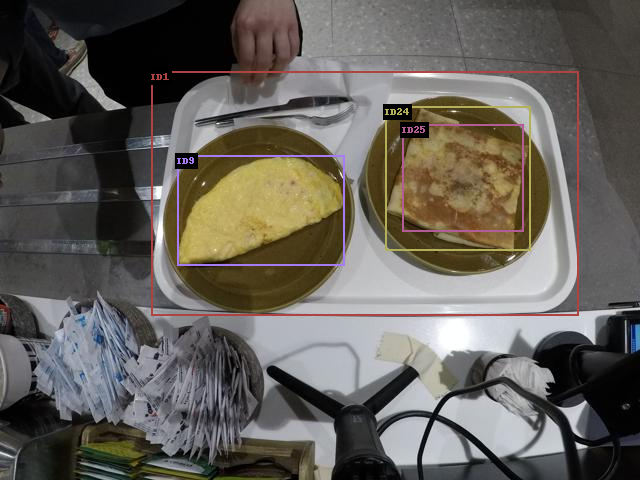

In [199]:
color = list((random.randint(40, 240), random.randint(40, 255), random.randint(60, 255)) for i in range(129))

# def objects_threshold_scores(bboxes: torch.Tensor, 
#                          labels: torch.Tensor=None, 
#                          scores: torch.Tensor=None,
#                          threshold_score: float=0.5):
#     bboxes_copy = copy.deepcopy(bboxes)
#     labels_copy = copy.deepcopy(labels)
#     scores_copy = copy.deepcopy(scores)

#     bboxes = list()
#     labels, scores = list(), list()
#     for i, score in enumerate(scores_copy):
#         if score >= threshold_score:
#             bboxes.append(bboxes_copy[i])
#             labels.append(labels_copy[i])
#             scores.append(score)
    
#     bboxes = torch.Tensor(bboxes).unsqueeze(dim=0)
#     labels = torch.Tensor(labels)
#     scores = torch.Tensor(scores)

#     del bboxes_copy, labels_copy, scores_copy

#     return bboxes, labels, scores

def show_image_with_objects(image: np.array, 
                            bboxes: torch.Tensor, 
                            labels: torch.Tensor=None, 
                            scores: torch.Tensor=None,
                            threshold_score: float=0.5):

    image = Image.fromarray(image.transpose(1, 2, 0))

#     random.shuffle(color)

    if scores != None:
        bboxes, labels, scores = objects_threshold_scores(bboxes, labels, scores, threshold_score)

    for i in range(len(bboxes)):
        draw = ImageDraw.Draw(image)
        draw.rectangle(bboxes[i].numpy(), outline = color[labels[i].int()], width=2)

        if scores != None:
            bbox = draw.textbbox((bboxes[i][0], bboxes[i][1]), f"ID{int(labels[i])} {scores[i] * 100:.2f}%")
            draw.rectangle((bbox[0]-2, bbox[1]-2, bbox[2]+2, bbox[3]+2), fill=(0, 0, 0))
            draw.text((bboxes[i][0], bboxes[i][1]), f"ID{int(labels[i])} {scores[i] * 100:.2f}%", color[labels[i].int()])
        else:
            bbox = draw.textbbox((bboxes[i][0], bboxes[i][1]), f"ID{int(labels[i])}")
            draw.rectangle((bbox[0]-2, bbox[1]-2, bbox[2]+2, bbox[3]+2), fill=(0, 0, 0))
            draw.text((bboxes[i][0], bboxes[i][1]), f"ID{int(labels[i])}", color[labels[i]])
    return image

img, target = random.choice(data)
show_image_with_objects(img, target['boxes'], target['labels'])

# Prepare the transformation for augmentations

In [15]:
train_transform = albumentations.Compose(
    [
        albumentations.Resize(height=FUSED_SHAPE[1], width=FUSED_SHAPE[0]),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.Rotate(p=0.5),
        albumentations.Blur(p=0.1),
        albumentations.CLAHE(p=0.1),
        albumentations.ToGray(p=0.1),
        albumentations.MedianBlur(p=0.1),
        albumentations.pytorch.transforms.ToTensorV2()
    ],
    bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels'])
)

test_transform = albumentations.Compose(
    [
        albumentations.Resize(height=FUSED_SHAPE[1], width=FUSED_SHAPE[0]),
        albumentations.pytorch.transforms.ToTensorV2()
    ],
    bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels'])
)

# Separation of data into training, validation and test samples

In [150]:
train_data, test_data = train_test_split(list(zip(image_path_list, objects)), test_size=0.3, shuffle=True, random_state=42)
val_data, data_data = train_test_split(test_data, test_size=0.1, shuffle=True, random_state=42)

train_data = AlfaFoodDataset(images=list(items[0] for items in train_data),
                             objects=list(items[1] for items in train_data),
                             transform=None)

test_data = AlfaFoodDataset(images=list(items[0] for items in test_data),
                            objects=list(items[1] for items in test_data),
                            transform=test_transform )

val_data = AlfaFoodDataset(images=list(items[0] for items in val_data),
                           objects=list(items[1] for items in val_data),
                           transform=test_transform )

In [17]:
for image, target in train_data:
    for bbox in target['boxes']:
        if bbox[0] > 640:
            print(bbox[0])

(3, 480, 640)


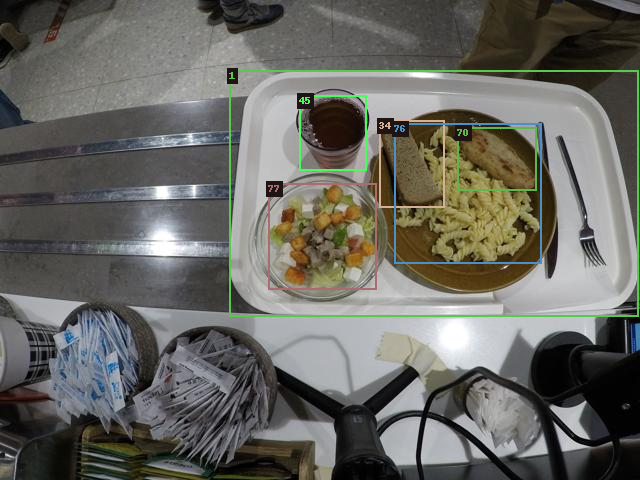

In [18]:
img, target = train_data[5]
print(img.shape)
show_image_with_objects(img, target['boxes'], target['labels'])

# Create Dataloaders

In [19]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataloader = torch.utils.data.DataLoader(dataset=train_data,
                                               batch_size=8,
                                               shuffle=True,
                                               num_workers=os.cpu_count(),
                                               collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(dataset=val_data,
                                             batch_size=2,
                                             shuffle=False,
                                             num_workers=os.cpu_count(),
                                             collate_fn=collate_fn)
test_dataloader = torch.utils.data.DataLoader(dataset=test_data,
                                              batch_size=2,
                                              shuffle=False,
                                              num_workers=os.cpu_count(),
                                              collate_fn=collate_fn)

# Create model

In [22]:
class FasterRCNN_ResNet50(torch.nn.Module):
    def __init__(self, num_classes: int=127) -> None:
        super().__init__()

        self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=True)
        num_classes = num_classes + 2
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

        for child in list(self.model.children()):
              for param in child.parameters():
                    param.requires_grad = True

    def predict(self, X: torch.Tensor) -> torch.Tensor:
        '''
        For predict bboxes and labels
        '''
        return self.model(X)

    # To calculate the loss function
    def forward(self, images: List[torch.Tensor], annotation: List[Dict[str, torch.Tensor]]) -> Dict[str, int]:
        return self.model(images, annotation)

model = FasterRCNN_ResNet50(num_classes=data.num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 168MB/s]  


# Function for calculate IoU metrics

In [20]:
def get_IoU(bbox1: torch.Tensor, bbox2: torch.Tensor) -> float:
  x_left = max(bbox1[0], bbox2[0])
  x_right = min(bbox1[2], bbox2[2])

  y_bottom = max(bbox1[1], bbox2[1])
  y_top = min(bbox1[3], bbox2[3])

  intersection_bboxes = (y_top - y_bottom) * (x_right - x_left)
  union_bboxes = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1]) + \
                 (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1]) - intersection_bboxes

  return intersection_bboxes / union_bboxes

assert(get_IoU(target['boxes'][0], target['boxes'][0]) == 1)

# Declare functions for training, validation and testing

In [21]:
def train_step(device: torch.device,
               model: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               dataloader: torch.utils.data.DataLoader,
               criterion: torch.nn.Module = None,
               scheduler: torch.optim.lr_scheduler = None):

  model.to(device)
  model.train()

  train_loss = 0
  torch.cuda.empty_cache()

  time_epoch_start = time()

  for batch, (images, annotations) in enumerate(dataloader):

    images = [torch.Tensor(image).to(device) for image in images]
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

    if criterion == None:
      loss_dict = model(images, annotations)
      loss = sum(loss for loss in loss_dict.values())
    else:
      pass
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if scheduler is not None:
      scheduler.step()

#     print(f"LOSSES: {loss}")
    # print(model(images[0]))

  train_loss = train_loss / len(dataloader)
  time_epoch_end = time() - time_epoch_start

  return train_loss, time_epoch_end



@torch.no_grad()
def validation_step(device: torch.device,
                    model: torch.nn.Module,
                    dataloader: torch.utils.data.DataLoader,
                    criterion: torch.nn.Module = None):
  model.to(device)
  model.eval()

  val_loss = 0
  min_val_loss = 1e6
  torch.cuda.empty_cache()

  time_epoch_start = time()
  with torch.inference_mode():
    for batch, (images, annotations) in enumerate(dataloader):

      images = [torch.Tensor(image).to(device) for image in images]
      annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

      if criterion == None:
        model.train()
        loss_dict = model(images, annotations)
        # print(loss_dict)
        loss = sum(loss for loss in loss_dict.values())
        model.eval()
      else:
        pass
      val_loss += loss.item()

      # print(f"TESTING MODEL {model.predict(images)}")
      # break
      # print(f"LOSSES: {loss}")

  val_loss /= len(dataloader)
  time_epoch_end = time() - time_epoch_start

  # val_loss = validate(epoch)
  if val_loss < min_val_loss:
      print('NEW BEST MODEL!')
      torch.save(model.state_dict(), 'best_model.pth')
      min_val_loss = val_loss
  torch.save(model.state_dict(), 'latest_model.pth')

  return val_loss, time_epoch_end



def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          epochs: int,
          device: torch.device):
  for epoch in tqdm(range(epochs)):
    train_loss, train_train_epoch = train_step(model=model,
                                        dataloader=train_dataloader,
                                        optimizer=optimizer,
                                        device=device)

    print(f"EPOCH: {epoch+1} | TRAIN LOSS: {train_loss} | TRAIN TIME: {train_train_epoch}")

    val_loss, val_time_epoch = validation_step(model=model,
                                          dataloader=test_dataloader,
                                          device=device)

    print(f"EPOCH: {epoch+1} | VAL LOSS: {val_loss} | VAL TIME: {val_time_epoch}\n")

In [22]:
# LOSSES: {'loss_classifier': tensor(141.1330, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(2.4547, grad_fn=<DivBackward0>), 'loss_objectness': tensor(133.6202), 'loss_rpn_box_reg': tensor(8.3771)}

In [23]:
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=1e-4, weight_decay=1e-7)

train(model, train_dataloader, val_dataloader, optimizer, num_epochs, device)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH: 1 | TRAIN LOSS: 2.559449404376359 | TRAIN TIME: 335.97778272628784
NEW BEST MODEL!
EPOCH: 1 | VAL LOSS: 1.6049064407310638 | VAL TIME: 69.60041046142578

EPOCH: 2 | TRAIN LOSS: 1.4367553988414412 | TRAIN TIME: 334.76263451576233
NEW BEST MODEL!
EPOCH: 2 | VAL LOSS: 1.4428431028982558 | VAL TIME: 69.40532517433167

EPOCH: 3 | TRAIN LOSS: 1.3554726342699226 | TRAIN TIME: 334.97677278518677
NEW BEST MODEL!
EPOCH: 3 | VAL LOSS: 1.359319985447177 | VAL TIME: 69.7544777393341

EPOCH: 4 | TRAIN LOSS: 1.293686211516019 | TRAIN TIME: 334.56378698349
NEW BEST MODEL!
EPOCH: 4 | VAL LOSS: 1.3425530910610677 | VAL TIME: 69.90017294883728

EPOCH: 5 | TRAIN LOSS: 1.2131298324760724 | TRAIN TIME: 334.7339253425598
NEW BEST MODEL!
EPOCH: 5 | VAL LOSS: 1.1808324810636945 | VAL TIME: 69.84433269500732

EPOCH: 6 | TRAIN LOSS: 1.1526837768001361 | TRAIN TIME: 334.8561646938324
NEW BEST MODEL!
EPOCH: 6 | VAL LOSS: 1.1836505324479594 | VAL TIME: 69.50612711906433

EPOCH: 7 | TRAIN LOSS: 1.085553760414

In [25]:
import pathlib

path_to_weights_model = pathlib.Path("/kaggle/input/faster-rcnn/pytorch/default/1/best_model (5).pth")

model.load_state_dict(torch.load(path_to_weights_model, map_location=torch.device('cpu')))

<All keys matched successfully>

In [120]:
def objects_threshold_scores(bboxes: torch.Tensor, 
                         labels: torch.Tensor=None, 
                         scores: torch.Tensor=None,
                         threshold_score: float=0.1):
    bboxes_copy = copy.deepcopy(bboxes)
    labels_copy = copy.deepcopy(labels)
    scores_copy = copy.deepcopy(scores)

    bboxes = torch.Tensor([])
    labels, scores = list(), list()
    for i, score in enumerate(scores_copy):
        if score >= threshold_score:
            bboxes = torch.cat((bboxes, bboxes_copy[i].unsqueeze(dim=0)), dim=0)
            labels.append(labels_copy[i])
            scores.append(score)
    
#     bboxes = torch.Tensor(bboxes).unsqueeze(dim=0)
    labels = torch.Tensor(labels)
    scores = torch.Tensor(scores)

    del bboxes_copy, labels_copy, scores_copy

    return bboxes, labels, scores

(3, 480, 640)
7 7


(-0.5, 639.5, 479.5, -0.5)

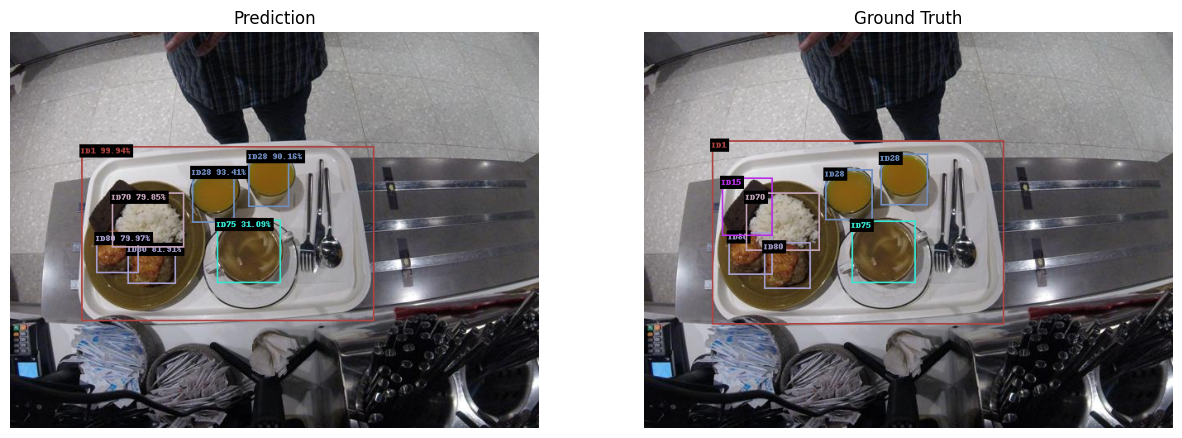

In [200]:
image, target = train_data[71]
print(image.shape)
# images = [torch.Tensor(image.transpose(2, 0, 1)).to(device) for image in images]
# annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

with torch.no_grad():
    model.eval()
    model.to(device)
    outputs = model.predict(torch.Tensor(image).unsqueeze(dim=0).to(device))
bboxes, labels, scores = objects_threshold_scores(outputs[0]['boxes'].to('cpu'), outputs[0]['labels'], outputs[0]['scores'], 0.3)
print(len(labels), len(bboxes))

fig, axes = plt.subplots(1, 2, figsize=(15, 7))
axes[0].imshow(show_image_with_objects(image, bboxes, labels, scores, 0.3))

axes[1].imshow(show_image_with_objects(image, target['boxes'], target['labels']))

axes[0].set_title("Prediction")
axes[1].set_title("Ground Truth")

axes[0].axis('off')
axes[1].axis('off')